In [1]:
from __future__ import print_function
from __future__ import division

import make_dictionaries
import os
import math
import params

import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time
from voronoi_2d_binning import voronoi_2d_binning
from sklearn.neighbors import NearestNeighbors

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
def voronoi_binning(R50, Mr, n_rect_bins=500, n_per_voronoi_bin=5000,save=False):
    
    rect_bin_val, R50_bin_edges, Mr_bin_edges = np.histogram2d(R50, Mr, n_rect_bins)

    rect_bins_table = Table(data=[R50_bin_edges, Mr_bin_edges],
                            names=['R50_bin_edges', 'Mr_bin_edges'])
    rect_bins_table.meta['nrectbin'] = n_rect_bins # add value for number of 
    # bins to the table. 
    
    # Get bin centres + number of bins:
    R50_bin_centres = 0.5*(R50_bin_edges[:-1] + R50_bin_edges[1:])
    Mr_bin_centres = 0.5*(Mr_bin_edges[:-1] + Mr_bin_edges[1:]) 
    n_R50_bins = len(R50_bin_centres)
    n_Mr_bins = len(Mr_bin_centres)

    # Get ranges:
    R50_bins_min, Mr_bins_min = map(np.min, (R50_bin_centres, Mr_bin_centres))
    R50_bins_max, Mr_bins_max = map(np.max, (R50_bin_centres, Mr_bin_centres))
    R50_bins_range = R50_bins_max - R50_bins_min
    Mr_bins_range = Mr_bins_max - Mr_bins_min
    
    # 'Ravel' out the coordinate bins (.'. length=n_bin*n_bin)
    R50_bin_coords = R50_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).ravel()
    Mr_bin_coords = Mr_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).T.ravel()

    # Only keep bins that contain a galaxy:
    signal = rect_bin_val.ravel() # signal=number of gals.
    ok_bin = (signal > 0).nonzero()[0]
    signal = signal[ok_bin]

    # Normalise x + y to be between 0 and 1:
    x = (R50_bin_coords[ok_bin] - R50_bins_min) / R50_bins_range
    y = (Mr_bin_coords[ok_bin] - Mr_bins_min) / Mr_bins_range

    # Voronoi_2d_binning aims for a target S/N
    noise = np.sqrt(signal)
    targetSN = np.sqrt(n_per_voronoi_bin)

    output = voronoi_2d_binning(x, y, signal, noise, targetSN, plot=0, quiet=1, wvt=True)
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = output

    vbin = np.unique(binNum)
    count = (sn**2).astype(np.int) # N_gals for each voronoi bin.
    R50_vbin_mean = xBar * R50_bins_range + R50_bins_min
    Mr_vbin_mean = yBar * Mr_bins_range + Mr_bins_min
    
    vbins_table = Table(data=[vbin, R50_vbin_mean, Mr_vbin_mean,
                              count, nPixels],
                        names=['vbin', 'R50', 'Mr', 
                               'count_gals', 'count_rect_bins'])
    vbins_table.meta['nrectbin'] = n_rect_bins
    vbins_table.meta['nperbin'] = n_per_voronoi_bin

    # Populate elements of the rectangular grid with
    # the voronoi bin indices and counts
    rect_bin_voronoi_bin = np.zeros(np.product(rect_bin_val.shape), np.int) - 1
    rect_bin_voronoi_bin[ok_bin] = binNum
    rect_bin_count = np.zeros_like(rect_bin_voronoi_bin)
    rect_bin_count[ok_bin] = count
    
    rect_vbins_table = Table(data=[R50_bin_coords, Mr_bin_coords,
                             rect_bin_voronoi_bin],
                             names=['R50', 'Mr', 'vbin'])
    rect_bins_table.meta['nrectbin'] = n_rect_bins
    rect_bins_table.meta['nperbin'] = n_per_voronoi_bin
    
    if save == True:
        rect_bins_table.write(save_directory + 'rect_bins_table.fits', overwrite=True)
        vbins_table.write(save_directory + 'vbins_table.fits', overwrite=True)
        rect_vbins_table.write(save_directory + 'rect_vbins_table.fits', overwrite=True)
        
    plt.hist(vbins_table['count_gals'],histtype='stepfilled',color='b',alpha=0.5,linewidth=0)
    ylims = plt.gca().get_ylim()
    plt.vlines(n_per_voronoi_bin,ylims[0],ylims[1],color='k',linewidth=3,linestyle='dotted')
    plt.ylabel('$N_{bin}$')
    plt.xlabel('$N_{gal}$')
    
    # rect_bins_table: contains all of the bin edges (len=N_bins)
    # rect_vbins_table: has bin centre values + assigned v-bin (len=N_bins**2)
    # vbins_table: for each bin, contains the number of gals, Mr+R50 mean
    # values + the number of rectangular bins it is made up of (len=N_v-bins)
    return rect_bins_table, vbins_table, rect_vbins_table, Mr_bins_min, Mr_bins_range, R50_bins_min, R50_bins_range

In [4]:
def redshift_binning(data,voronoi_bins,min_gals=100):
    
    redshift = data['REDSHIFT_1']
    z_bins = []

    for N in np.unique(voronoi_bins):
        inbin = voronoi_bins == N
        n_with_morph = np.sum(inbin)
        n_zbins = n_with_morph/min_gals
        z = redshift[inbin]
        z = np.sort(z)
        bin_edges = np.linspace(0, len(z)-1, n_zbins+1, dtype=np.int)
        z_edges = z[bin_edges]
        z_edges[0] = 0
        z_edges[-1] = 1
        
        z_bins.append(z_edges)
        
    return z_bins

In [5]:
# Need to assign all of the galaxies to correct bins.

def voronoi_assignment(data, rect_bins_table, rect_vbins_table,
                       Mr_bins_min, Mr_bins_range, R50_bins_min, R50_bins_range,
                       reassign=False):
    R50_bin_edges = rect_bins_table['R50_bin_edges']
    Mr_bin_edges = rect_bins_table['Mr_bin_edges']
    n_R50_bins = len(R50_bin_edges) - 1
    n_Mr_bins = len(Mr_bin_edges) - 1
    
    R50 = np.log10(data['PETROR50_R_KPC'])
    Mr = data['PETROMAG_MR']
    
    # get the R50 and Mr bin for each galaxy in the sample
    R50_bins = np.digitize(R50, bins=R50_bin_edges).clip(1, n_R50_bins)
    Mr_bins = np.digitize(Mr, bins=Mr_bin_edges).clip(1, n_Mr_bins)

    # convert R50 and Mr bin indices to indices of bins
    # in the combined rectangular grid
    rect_bins = (Mr_bins - 1) + n_Mr_bins * (R50_bins - 1)

    # get the voronoi bin for each galaxy in the sample
    rect_bin_vbins = rect_vbins_table['vbin']
    voronoi_bins = rect_bin_vbins[rect_bins]
    
    if reassign is True: # Find nearest bin if none available
        rect_bins_assigned = rect_vbins_table[rect_vbins_table['vbin'] != -1]
        R50_bin = rect_bins_assigned['R50']
        Mr_bin = rect_bins_assigned['Mr']
        
        x = (R50_bin - R50_bins_min) / R50_bins_range
        y = (Mr_bin - Mr_bins_min) / Mr_bins_range
        
        unassigned = voronoi_bins == -1
        R50u = (R50[unassigned] - R50_bins_min) / R50_bins_range
        Mru = (Mr[unassigned] - Mr_bins_min) / Mr_bins_range
        
        xy = (np.array([R50u,Mru])).T
        xy_ref = (np.array([x,y])).T
        
        nbrs = NearestNeighbors(n_neighbors=1,algorithm='ball_tree').fit(xy_ref,xy)
        d,i = nbrs.kneighbors(xy)
        i = i.squeeze()
        vbins_reassigned = rect_bins_assigned['vbin'][i]
        voronoi_bins[voronoi_bins == -1] = vbins_reassigned
    
    return voronoi_bins

In [6]:
def redshift_assignment(data,vbins,zbin_ranges):
    
    zbins = np.zeros(len(data))
    
    for v in (np.unique(vbins)):
        z_range = zbin_ranges[v]
        v_data = data[vbins == v]['REDSHIFT_1']
        z_bin = np.digitize(v_data,bins=z_range)
        zbins[vbins == v] = z_bin
        
    return zbins

In [7]:
def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction'):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    if n_morph > 4:
        l = 20/x_dimension
    else:
        l = 10/x_dimension
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=True,sharey=True,figsize=(l*x_dimension,l*y_dimension))
    if n_morph >= 3:
        for ax in axes[-1,:]:
            ax.set_xlabel(xlabel)
        for ax in axes[:,0]:
            ax.set_ylabel(ylabel) 
    else:
        axes[0].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)
        axes[1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes

In [8]:
def find_nearest(reference,values):
    i = np.zeros(len(values))
    for m,value in enumerate(values):
        i[m] = (np.abs(reference-value)).argmin()
    return i.astype(int)


def sort_data(D):

    D_i = np.arange(len(D))
    order = np.argsort(D)
    D_sorted = D[order]
    D_i_sorted = D_i[order]
    cumfrac = np.linspace(0,1,len(D))
    
    D_table = Table(np.array([D_i_sorted,D_sorted,cumfrac]).T,names=('index','fv','cumfrac'))
    reorder = np.argsort(D_table['index'])
    D_table = D_table[reorder]
    
    for f in np.unique(D_table['fv']):
        f_select = D_table['fv'] == f
        D_table['cumfrac'][f_select] = np.mean(D_table['cumfrac'][f_select])
    
    return D_table

In [9]:
def debias_by_bins(data,vbins,zbins):
    
    fraction_column = question + '_' + answer + '_weighted_fraction'
    data_column = data[fraction_column]
    debiased_column = np.zeros(len(data_column))

    for v in np.unique(vbins):
        select_v = vbins == v
        zbins_v = zbins[select_v]
        
        data_v0 = data_column[(select_v) & (zbins == 1)]
        v0_table = sort_data(data_v0)

        for z in np.unique(zbins_v):
            select_z = zbins == z
    
            data_vz = data_column[(select_v) & (select_z)]
            vz_table = sort_data(data_vz)
    
            debiased_i = find_nearest(v0_table['cumfrac'],vz_table['cumfrac'])
            debiased_fractions = v0_table['fv'][debiased_i]
            
            debiased_column[(select_v) & (select_z)] = debiased_fractions
    
    debiased_column[data_column == 0] = 0 # Don't 'debias up' 0s.
    debiased_column[data_column == 1] = 1 # Don't 'debias down' the 1s.
    
    return debiased_column

In [10]:
def bin_data(data,n_vbins=40,signal=100,plot=True):
    
    R50 = data['PETROR50_R_KPC'][fv_nonzero]
    rect_bins_table,vbins_table,rect_vbins_table,Mr_bins_min,Mr_bins_range,R50_bins_min,R50_bins_range = voronoi_binning(np.log10(R50),
                                                                                                                         data['PETROMAG_MR'][fv_nonzero],
                                                                                                                         n_per_voronoi_bin=np.sum(fv_nonzero)/n_vbins)

    vbins = voronoi_assignment(data[fv_nonzero],rect_bins_table,rect_vbins_table,Mr_bins_min,
                               Mr_bins_range, R50_bins_min, R50_bins_range)
    zbin_ranges = redshift_binning(data[fv_nonzero],vbins,min_gals=signal)
    
    vbins = voronoi_assignment(data, rect_bins_table, rect_vbins_table,
                           Mr_bins_min, Mr_bins_range, R50_bins_min, R50_bins_range,
                           reassign=True)
    
    zbins = redshift_assignment(data,vbins,zbin_ranges)
    
    N_v = np.unique(vbins)
    N_z = []
    
    for v in N_v:
        zbins_v = zbins[vbins == v]
        N_z.append(np.max(zbins_v))
        
    print('{} voronoi bins'.format(len(N_v)))
    print('{} redshift bins per voronoi bin'.format(np.mean(N_z)))
    
    if plot == True:
        
        relative_r = [((T-T.min())/(T.max()-T.min())) for T in [vbins_table['R50'],vbins_table['Mr']]]
        relative_r = relative_r[1]# + relative_r[1]
        r_sort = np.argsort(relative_r)

        for N in np.unique(vbins)[r_sort]:
            inbin = vbins == N
            plt.plot(data['PETROR50_R_KPC'][inbin],data['PETROMAG_MR'][inbin], '.')
    
        for N in range(len(vbins_table)):
            x_text_pos = 10**(vbins_table['R50'][N])
            y_text_pos = vbins_table['Mr'][N]
            plt.text(x_text_pos,y_text_pos,'{}'.format(N),
                     color='w',horizontalalignment='center',
                     verticalalignment='center')

        plt.ylabel(r"$M_r$")
        plt.xlabel(r"$R_{50}$ (kpc)")
        plt.xscale('log')
        _ = plt.axis((0.5, 60, -18, -25))
        
        plt.savefig('figures/voronoi_binning/{}_{}.png'.format(question,answer))
        
    return vbins,zbins,vbins_table

In [11]:
source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5#np.log10(0.1)
max_log_fv = 0.01

Question to be debiased: t01_smooth_or_features


In [12]:
data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

low_z_lim = 0.03
data = data[data['REDSHIFT_1'] > low_z_lim]

# For this code, go through each of the answers separately
answers = questions[question]['answers']
answer = answers[1]
raw_column = data[question + '_' + answer + '_weighted_fraction']
fv_nonzero = raw_column > 0 # Select only the non-zero data to add to the 'signal' for each bin.

Loaded galaxy data...
Loaded questions...
Loaded functions...


Bin-accretion...
2070  initial bins.
Reassign bad bins...
25  good bins.
Modified Lloyd algorithm...
23  iterations.
Unbinned pixels:  0  /  39099
Fractional S/N scatter (%): 9.6644937707
25 voronoi bins
82.96 redshift bins per voronoi bin


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:59: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


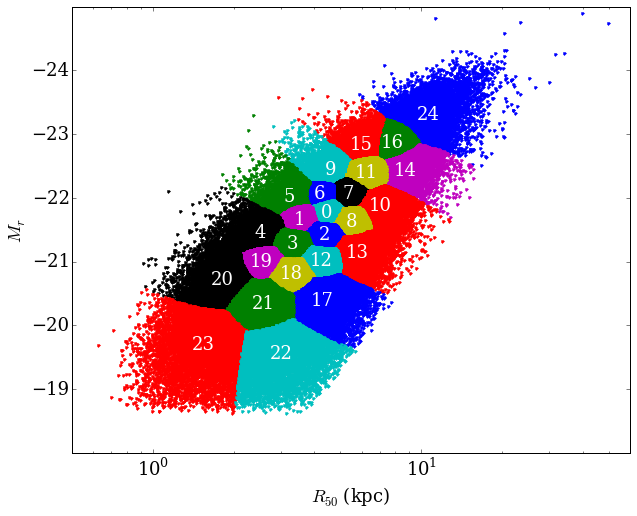

In [13]:
vbins,zbins,vbins_table = bin_data(data,plot=True)

In [14]:
debiased_bins = debias_by_bins(data,vbins,zbins)

In [15]:
volume_limit = (data['PETROMAG_MR'] < -21) & (data['REDSHIFT_1'] < 0.085)

hi_z = (data['REDSHIFT_1'] < 0.085) & (data['REDSHIFT_1'] > 0.075)
low_z = (data['REDSHIFT_1'] < 0.04) & (data['REDSHIFT_1'] > 0.03)

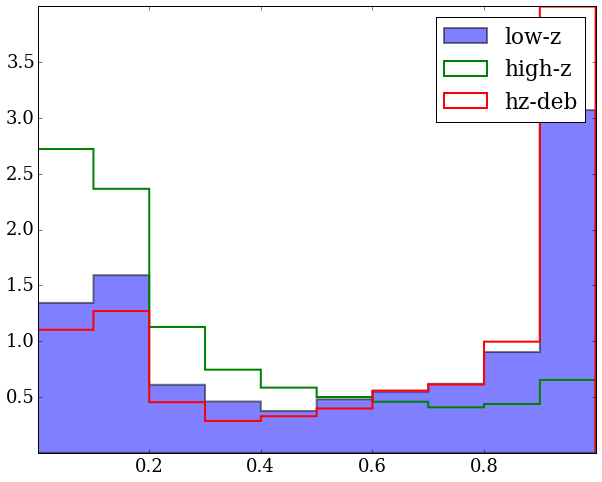

In [17]:
# Raw low-z data:
fv_raw = data[question + '_' + answer + '_weighted_fraction']
low_z_data = fv_raw[(volume_limit) & (low_z)]
hi_z_data = fv_raw[(volume_limit) & (hi_z)]
hi_z_debiased = debiased_bins[(volume_limit) & (hi_z)]

labels = ['low-z','high-z','hz-deb']

for m,d in enumerate([low_z_data,hi_z_data,hi_z_debiased]):
    
    if m == 0:
        t = 'stepfilled'
        a = 0.5
    else:
        t='step'
        a = 1
    
    plt.hist(d,bins=np.linspace(0,1,11),linewidth=2,label=labels[m]
             ,histtype=t,alpha=a,normed=True)
    
    plt.legend()